# Quora Question Pairs

# 1. Business Problem

## 1.1 Description

Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

    Credits: Kaggle
###### Problem Statement:
* Identify which questions asked on Quora are duplicates of questions that have already been asked.
*  This could be useful to instantly provide answers to questions that have already been answered.
*  We are tasked with predicting whether a pair of questions are duplicates or not.

## 1.2 Sources/Useful Links

* Source : https://www.kaggle.com/c/quora-question-pairs 

###### Useful Links
* Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
* Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
* Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
* Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

## 1.3 Real world/Business Objectives and Constraints

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

# 2. Machine Learning Probelm

## 2.1 Data

###### 2.1.1 Data Overview
- Data will be in a file Train.csv 
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate 
- Size of Train.csv - 60MB 
- Number of rows in Train.csv = 404,290

###### 2.1.2 Example Data point
1. "id","qid1","qid2","question1","question2","is_duplicate"
2. "0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
3. "1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
4. "7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
5. "11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"

## 2.2 Mapping the real world problem to an ML problem

#### 2.2.1 Type of Machine Leaning Problem
It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not.

#### 2.2.2 Performance Metric
 Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

 Metric(s):

   * log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
   * Binary Confusion Matrix

## 2.3 Train and Test Construction

* We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with.

# 3. Exploratory Data Analysis

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

## 3.1 Reading data and basic stats

In [0]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [0]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
df.info(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [0]:
y_true = df["is_duplicate"]

We are given a minimal number of data fields here, consisting of:

  * id: Looks like a simple rowID
  * qid{1, 2}: The unique ID of each question in the pair
  * question{1, 2}: The actual textual contents of the questions.
  * is_duplicate: The label that we are trying to predict - whether the two questions are duplicates of each other.

### 3.2.1 Distribution of data points among output classes

* Number of duplicate(smilar) and non-duplicate(non similar) questions

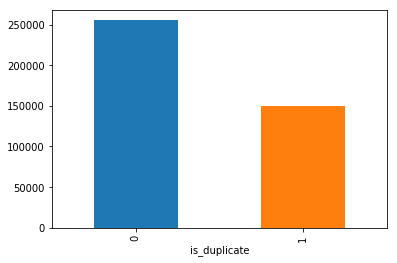

In [0]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [0]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [0]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


### 3.2.2 Number of unique questions

In [0]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



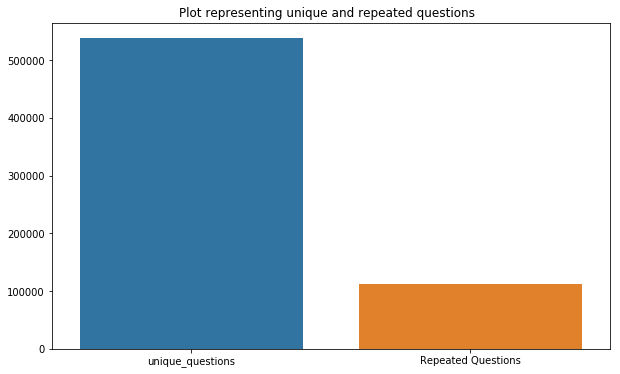

In [0]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

### 3.2.3 Checking for Duplicates

In [0]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


### 3.2.4 Number of occurrences of each question

Maximum number of times a single question is repeated: 157



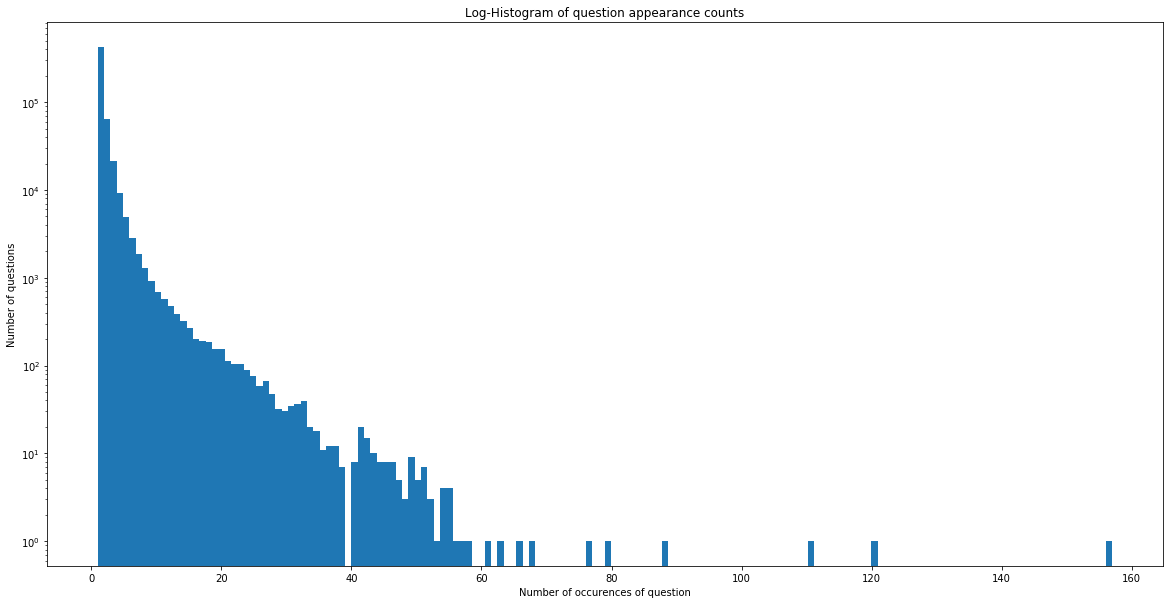

In [0]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 


### 3.2.5 Checking for NULL values

In [0]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [0]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


## 3.3 Basic Feature Extraction (before cleaning)

Let us now construct a few features like:

 * freq_qid1 = Frequency of qid1's
 * freq_qid2 = Frequency of qid2's
 * q1len = Length of q1
 * q2len = Length of q2
 * q1_n_words = Number of words in Question 1
 * q2_n_words = Number of words in Question 2
 * word_Common = (Number of common unique words in Question 1 and Question 2)
 * word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
 * word_share = (word_common)/(word_Total)
 * freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
 * freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

In [0]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,68765,16044,118786,How can I have more casual sex in India?,How can I have casual sex with a girl in India?,1,1,1,40,47,9,11,8.0,20.0,0.400000,2,0
1,173815,268046,268047,How much money does a TV weather person earn?,How much money does a mid level (appears on TV...,0,1,1,45,108,9,21,7.0,28.0,0.250000,2,0
2,329526,456195,456196,What or who has influenced your life the most ...,Which person has influenced your life the most?,1,1,1,54,47,11,8,5.0,19.0,0.263158,2,0
3,315567,56798,194687,"What's the difference between the title ""found...",What is the difference between the term founde...,1,1,1,67,63,9,10,4.0,17.0,0.235294,2,0
4,400919,370954,534288,Is it okay to be physical in a relationship fo...,At what stage in a relationship does an Indian...,0,1,1,63,93,13,17,7.0,30.0,0.233333,2,0


### 3.3.1 Analysis of some of the extracted features

In [0]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])


Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 4
Number of Questions with minimum length [question2] : 1


#### 3.3.1.1 Feature: word_share

C:\Users\BALARAMI REDDY\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

C:\Users\BALARAMI REDDY\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



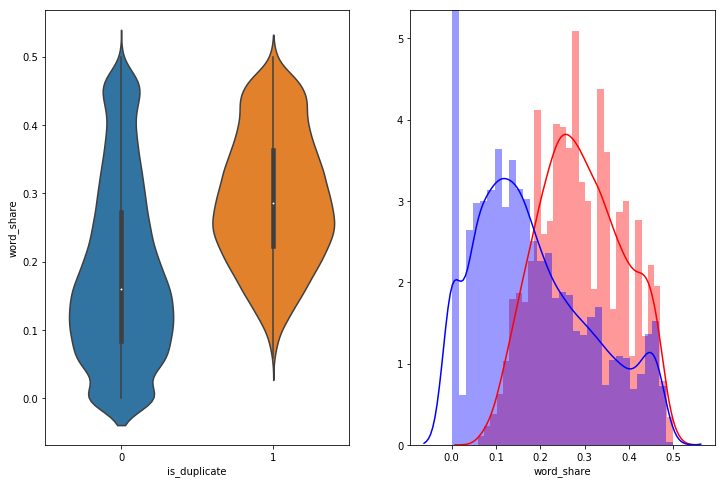

In [0]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

#### 3.3.1.2 Feature: word_Common

C:\Users\BALARAMI REDDY\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

C:\Users\BALARAMI REDDY\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



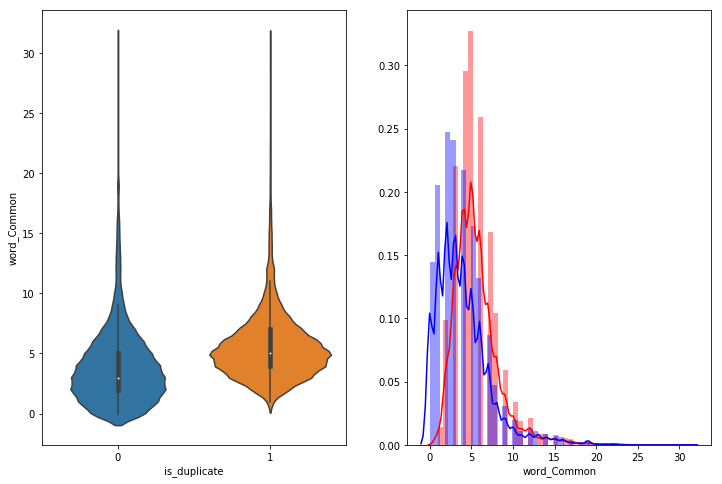

In [0]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

In [0]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,68765,16044,118786,How can I have more casual sex in India?,How can I have casual sex with a girl in India?,1,1,1,40,47,9,11,8.0,20.0,0.40,2,0
1,173815,268046,268047,How much money does a TV weather person earn?,How much money does a mid level (appears on TV...,0,1,1,45,108,9,21,7.0,28.0,0.25,2,0


## 3.4 Preprocessing of Text

* Preprocessing:
  * Removing html tags
  * Removing Punctuations
  * Performing stemming
  * Removing Stopwords
  * Expanding contractions etc.


In [0]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

## 3.5 Advanced Feature Extraction (NLP and Fuzzy Features)

Definition:

 * Token: You get a token by splitting sentence a space
 * Stop_Word : stop words as per NLTK.
 * Word : A token that is not a stop_word
Features:

 * cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2 
 * cwc_min = common_word_count / (min(len(q1_words), len(q2_words)) 

 * cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2 
 * cwc_max = common_word_count / (max(len(q1_words), len(q2_words)) 

 * csc_min : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 
 * csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops)) 

 * csc_max : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2
 * csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops)) 

 * ctc_min : Ratio of common_token_count to min lenghth of token count of Q1 and Q2
 * ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens)) 


 * ctc_max : Ratio of common_token_count to max lenghth of token count of Q1 and Q2
 * ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens)) 


 * last_word_eq : Check if First word of both questions is equal or not
 * last_word_eq = int(q1_tokens[-1] == q2_tokens[-1]) 


 * first_word_eq : Check if First word of both questions is equal or not
 * first_word_eq = int(q1_tokens[0] == q2_tokens[0]) 


 * abs_len_diff : Abs. length difference
 * abs_len_diff = abs(len(q1_tokens) - len(q2_tokens)) 


 * mean_len : Average Token Length of both Questions
 * mean_len = (len(q1_tokens) + len(q2_tokens))/2 


 * fuzz_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 


 * fuzz_partial_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 


 * token_sort_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 

 * token_set_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 

 * longest_substr_ratio : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2
 * longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

In [0]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [0]:
import fuzzywuzzy as fuzzy
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = df_sample
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,68765,16044,118786,how can i have more casual sex in india,how can i have casual sex with a girl in india,1,0.999967,0.749981,0.833319,0.714276,...,0.727266,1,1,2,10.0,93,80,80,75,0.365854
1,173815,268046,268047,how much money does a tv weather person earn,how much money does a mid level appears on tv...,0,0.666656,0.307690,0.999967,0.499992,...,0.333332,1,1,12,15.0,79,49,48,69,0.478261


In [0]:
y_true = df['is_duplicate']

### 3.5.1 Analysis of extracted features

#### 3.5.1.1 Plotting Word clouds

* Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
* We can observe the most frequent occuring words

In [0]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s',encoding ="utf-8")
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s',encoding ="utf-8")

Number of data points in class 1 (duplicate pairs) : 14932
Number of data points in class 0 (non duplicate pairs) : 25068


In [0]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt'),encoding="utf8").read()
textn_w = open(path.join(d, 'train_n.txt'),encoding="utf8").read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 815775
Total number of words in non duplicate pair questions : 1623200


#### Word Clouds generated from duplicate pair question's text

Word Cloud for Duplicate Question pairs


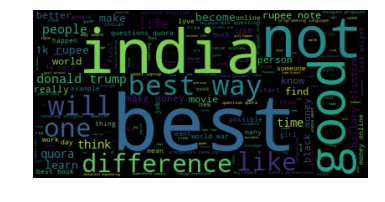

In [0]:
wc = WordCloud(background_color="black", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Word Clouds generated from non duplicate pair question's text

Word Cloud for non-Duplicate Question pairs:


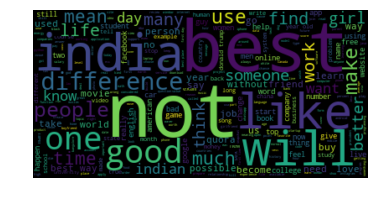

In [0]:
wc = WordCloud(background_color="black", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']

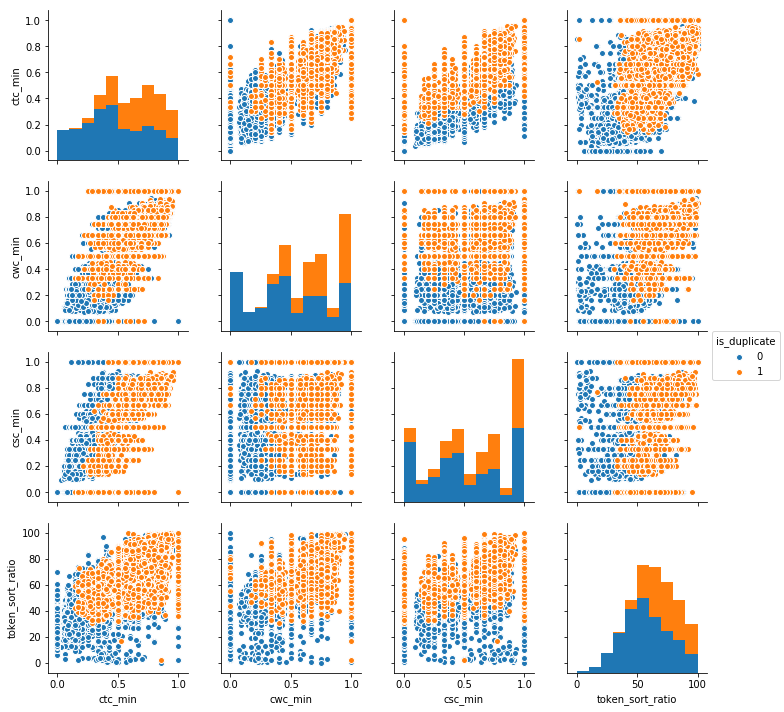

In [0]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

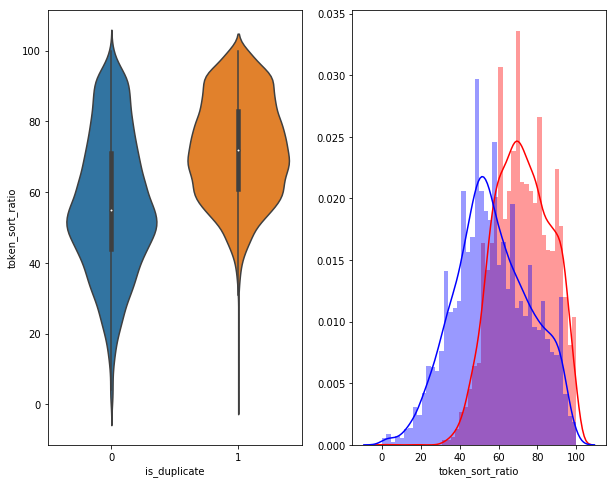

In [0]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

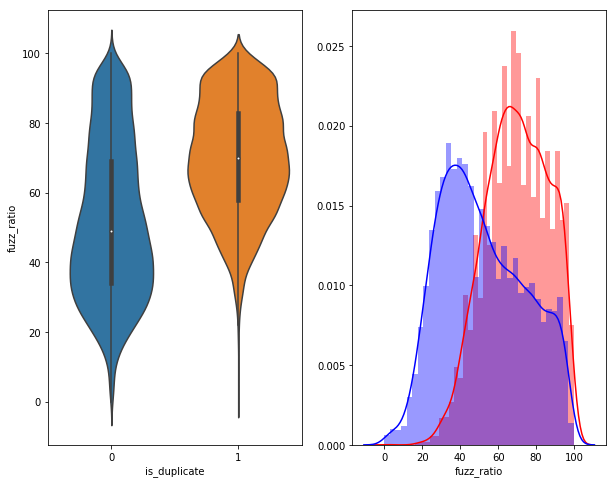

In [0]:
# Distribution of the fuzz_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

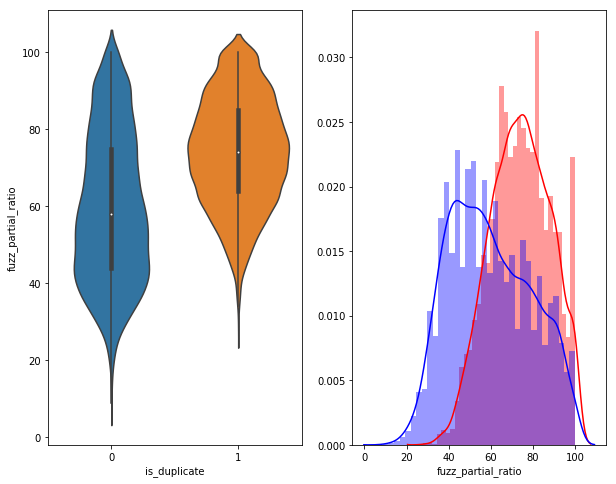

In [0]:
# Distribution of the fuzz_partial_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_partial_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_partial_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_partial_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

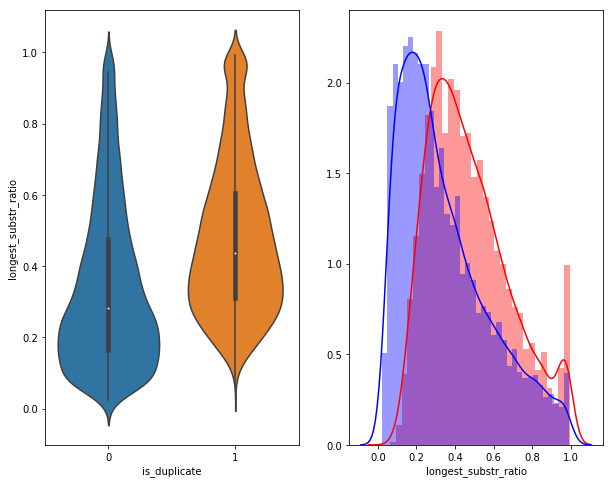

In [0]:
# Distribution of the longest_substr_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'longest_substr_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['longest_substr_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['longest_substr_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

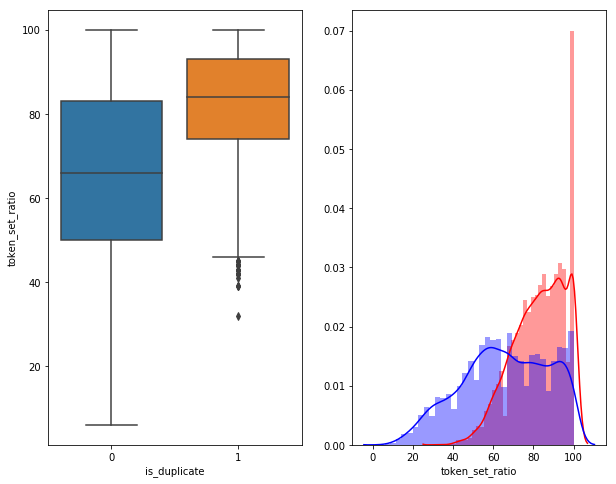

In [0]:
# Distribution of the token_set_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.boxplot(x = 'is_duplicate', y = 'token_set_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_set_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_set_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

### 3.5.2 Visualization

In [0]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [0]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.080s...
[t-SNE] Computed neighbors for 5000 samples in 0.944s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.143517
[t-SNE] Computed conditional probabilities in 0.517s
[t-SNE] Iteration 50: error = 82.7080002, gradient norm = 0.0492643 (50 iterations in 15.971s)
[t-SNE] Iteration 100: error = 70.8870544, gradient norm = 0.0087663 (50 iterations in 12.289s)
[t-SNE] Iteration 150: error = 69.1533127, gradient norm = 0.0050067 (50 iterations in 12.454s)
[t-SNE] Iteration 200: error = 68.4538422, gradient norm = 0.0041314 (50 iterations in 11.569s)
[t-SNE] Iteration 250: error = 68.0416794, gradient norm = 0.003

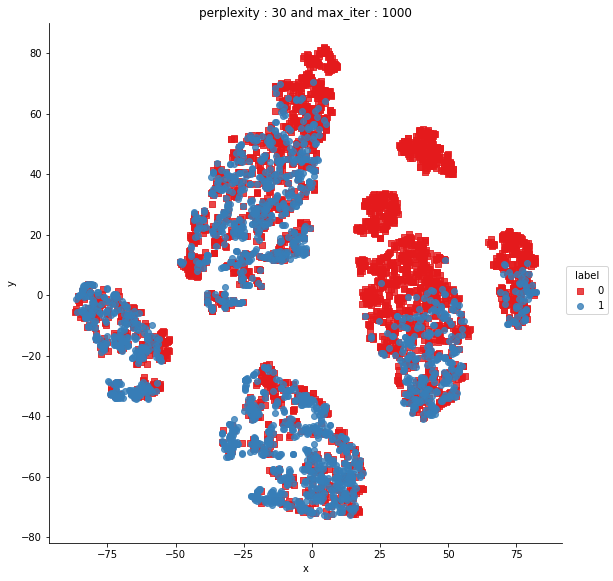

In [0]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()


In [0]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.025s...
[t-SNE] Computed neighbors for 5000 samples in 0.822s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.143517
[t-SNE] Computed conditional probabilities in 0.470s
[t-SNE] Iteration 50: error = 83.0560379, gradient norm = 0.0393791 (50 iterations in 32.294s)
[t-SNE] Iteration 100: error = 69.8144836, gradient norm = 0.0031539 (50 iterations in 16.345s)
[t-SNE] Iteration 150: error = 68.5873795, gradient norm = 0.0018377 (50 iterations in 13.298s)
[t-SNE] Iteration 200: error = 68.0681839, gradient norm = 0.0012082 (50 iterations in 13.701s)
[t-SNE] Iteration 250: error = 67.7559509, gradient norm = 0.000

In [0]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

## 3.6 Featurizing text data with tfidf


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy


In [0]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
df.shape

(404290, 6)

In [0]:
dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
df1 = dfnlp.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = dfnlp[['id','question1','question2']]
duplicate = dfnlp.is_duplicate

In [0]:
#df1=df1.drop('Unnamed: 0',axis=1)
df3 = df3.fillna(' ')
#assigning new dataframe with columns question(q1+q2) and id same as df3
new_df = pd.DataFrame()
new_df['questions'] = df3.question1 + ' ' + df3.question2
new_df['id'] = df3.id
df2['id']=df1['id']
new_df['id']=df1['id']
final_df = df1.merge(df2, on='id',how='left') #merging df1 and df2
X  = final_df.merge(new_df, on='id',how='left')#merging final_df and new_df

In [0]:
#removing id from X
X=X.drop('id',axis=1)
X.columns

Index(['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'questions'],
      dtype='object')

In [0]:
y=np.array(duplicate)

In [0]:
#splitting data into train and test

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=3,test_size=0.3)

In [0]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(14000, 27)
(14000,)
(6000, 27)
(6000,)


In [0]:
#seperating questions for tfidf vectorizer
X_train_ques = X_train['questions']
X_test_ques = X_test['questions']

X_train = X_train.drop('questions',axis=1)
X_test = X_test.drop('questions',axis=1)

In [0]:
#tfidf vectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,3),min_df=10)
X_train_tfidf=tf_idf_vect.fit_transform(X_train_ques)
X_test_tfidf=tf_idf_vect.transform(X_test_ques)

In [0]:
#adding tfidf features to our train and test data using hstack
from scipy.sparse import hstack
X_train = hstack((X_train.values,X_train_tfidf))
X_test= hstack((X_test.values,X_test_tfidf))
print(X_train.shape)
print(X_test.shape)

(14000, 5665)
(6000, 5665)


# 4. Machine Learning Models

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

## 4.1 Reading data from file and storing into sql table

In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [0]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6267142857142857 Class 1:  0.3732857142857143
---------- Distribution of output variable in train data ----------
Class 0:  0.37333333333333335 Class 1:  0.37333333333333335


## 4.2 Building a random model (Finding worst-case log-loss)

Log loss on Test Data using Random Model 0.8865283251964204


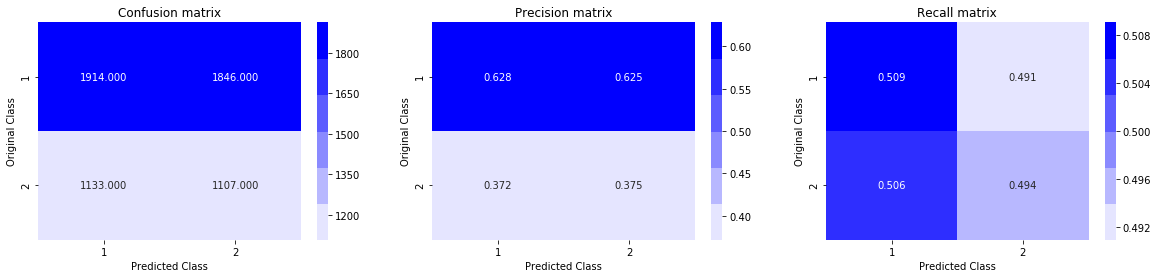

In [0]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

In [0]:
results=pd.DataFrame(columns=['Model', 'Featuraization', 'Hyperparameter', 'Train_loss','Test-loss', ])

## 4.3 Logistic Regression with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.5586584121606385
For values of alpha =  0.0001 The log loss is: 0.5617373142119728
For values of alpha =  0.001 The log loss is: 0.5679702608716167
For values of alpha =  0.01 The log loss is: 0.5666910020542417
For values of alpha =  0.1 The log loss is: 0.5595239651318704
For values of alpha =  1 The log loss is: 0.5745504407585222
For values of alpha =  10 The log loss is: 0.5964855686338079


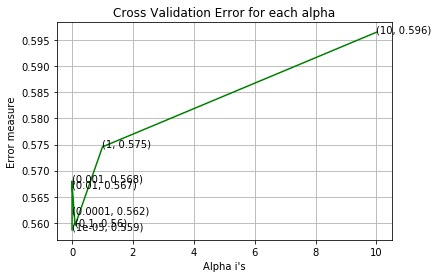

For values of best alpha =  1e-05 The train log loss is: 0.5581156750596382
For values of best alpha =  1e-05 The test log loss is: 0.5586584121606385
Total number of data points : 6000


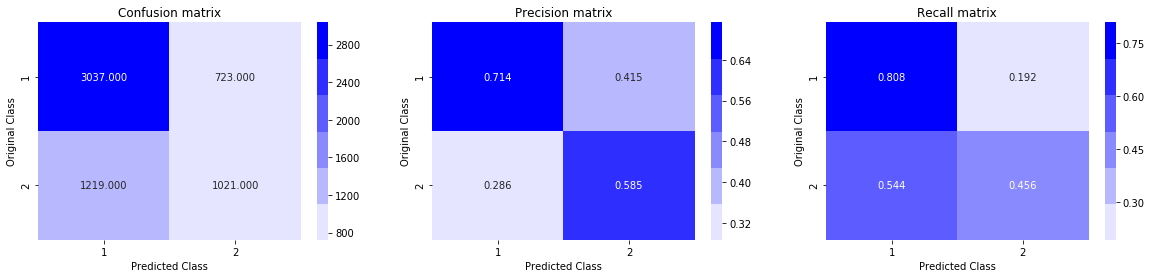

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …]) Fit linear model with Stochastic Gradient Descent.
# predict(X)  Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [0]:
new = ["Logistic-Regession",'TFIDF','alpha = 0.0001','0.558','0.558']
results.loc[0] = new

## 4.4 Linear SVM with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.550446894148761
For values of alpha =  0.0001 The log loss is: 0.5528632750942246
For values of alpha =  0.001 The log loss is: 0.5535812067373255
For values of alpha =  0.01 The log loss is: 0.5685455133067883
For values of alpha =  0.1 The log loss is: 0.5776858603050454
For values of alpha =  1 The log loss is: 0.6389790081517946
For values of alpha =  10 The log loss is: 0.6021480364885113


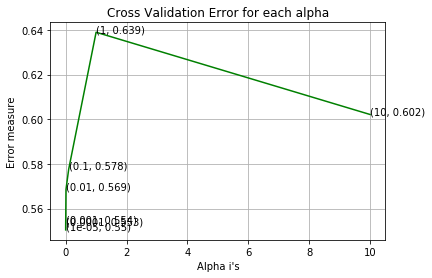

For values of best alpha =  1e-05 The train log loss is: 0.5498368201836388
For values of best alpha =  1e-05 The test log loss is: 0.550446894148761
Total number of data points : 6000


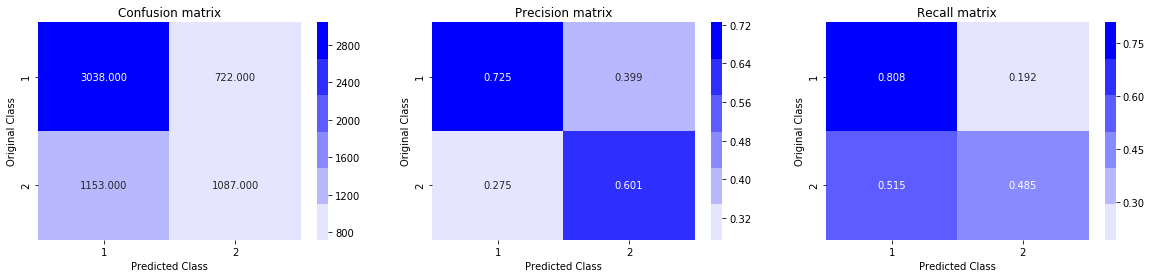

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …]) Fit linear model with Stochastic Gradient Descent.
# predict(X)  Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [0]:
new = ['Linear SVM','TFIDF','alpha = 10e-05','0.549','0.550']
results.loc[1] = new

## 4.5 XGBoost with hyperparameter tuning

In [0]:
# Finding optimal number of base learners using k-fold CV ->
base_learn = [x for x in range(30, 120,10)]
base_learn

[30, 40, 50, 60, 70, 80, 90, 100, 110]

In [0]:
# Learning rate values ->
#learning_rate = [x/10 for x in range(1,11)]
#learning_rate

In [0]:
# Max-depth values- >
#max_depth = [x for x in range(1,6)]
#max_depth

In [0]:
# Using RandomSearchCv to get optimal parameters ->
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
#params = {'n_estimators': base_learn, 'learning_rate': learning_rate, 'max_depth': max_depth}
#clf =xgb.XGBClassifier()
#model = GridSearchCV(clf, params)
#model.fit(X_train, y_train)

For values of base_learn =  30 The log loss is: 0.4363953610040852
For values of base_learn =  40 The log loss is: 0.4326155649595527
For values of base_learn =  50 The log loss is: 0.4288250465620343
For values of base_learn =  60 The log loss is: 0.42620346111346985
For values of base_learn =  70 The log loss is: 0.4237428695585786
For values of base_learn =  80 The log loss is: 0.4214714490612155
For values of base_learn =  90 The log loss is: 0.4201295316275006
For values of base_learn =  100 The log loss is: 0.4190961589634961
For values of base_learn =  110 The log loss is: 0.41781361769378744


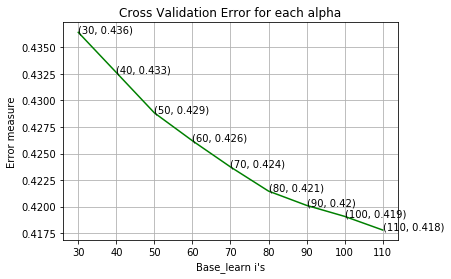

For values of best base_learn =  110 The train log loss is: 0.374724293108059
For values of best base_learn =  110 The test log loss is: 0.41781361769378744
Total number of data points : 6000


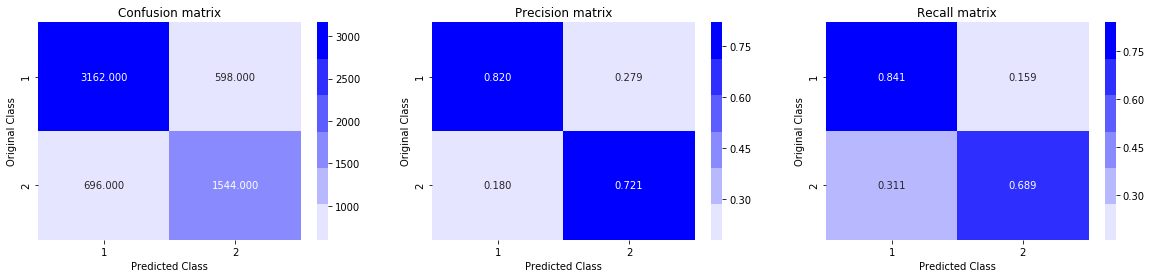

In [0]:
log_error_array=[]
for i in base_learn:
    clf = xgb.XGBClassifier(n_estimators = i,objective = 'binary:logistic',eval_metric = 'logloss',eta = 0.02,max_depth = 4)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of base_learn = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(base_learn, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((base_learn[i],np.round(txt,3)), (base_learn[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Base_learn i's")
plt.ylabel("Error measure")
plt.show()


best_base_learn = np.argmin(log_error_array)
clf = xgb.XGBClassifier(n_estimators = base_learn[best_base_learn],objective = 'binary:logistic',eval_metric = 'logloss',eta = 0.02,max_depth = 4 )
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best base_learn = ', base_learn[best_base_learn], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best base_learn = ', base_learn[best_base_learn], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [0]:
new = ['XGBoost','TFIDF','n-estimators = 100',0.374,0.417]
results.loc[2] = new

### Performance Table:

In [0]:
results

,Model,Featuraization,Hyperparameter,Train_loss,Test-loss
0,Logistic-Regession,TFIDF,alpha = 0.0001,0.558,0.558
1,Linear SVM,TFIDF,alpha = 10e-05,0.549,0.550
2,XGBoost,TFIDF,n-estimators = 100,0.374,0.417


### Conclusion:

1.XGBoost with tfidf featuraization and hyper parameter tuning gives best results (log loss = 0.417) compared to logistic       regression and Linear SVM

2.But time complexity is high compared to logistic regression and linear svm